<a href="https://colab.research.google.com/github/dennismathewjose/Applied-NLP-Learning-Materials/blob/main/IE7500_NLP_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### NAME: Dennis Jose
#### NUID: 002371781

## IE 7500: Applied Natural Language Processing in Engineering - Prof. Larson Ost

### Assignment 1: Regular Expressions & Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library.

In [34]:
## Reading the data and removing columns that are not important.
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [35]:
df.head() # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced.

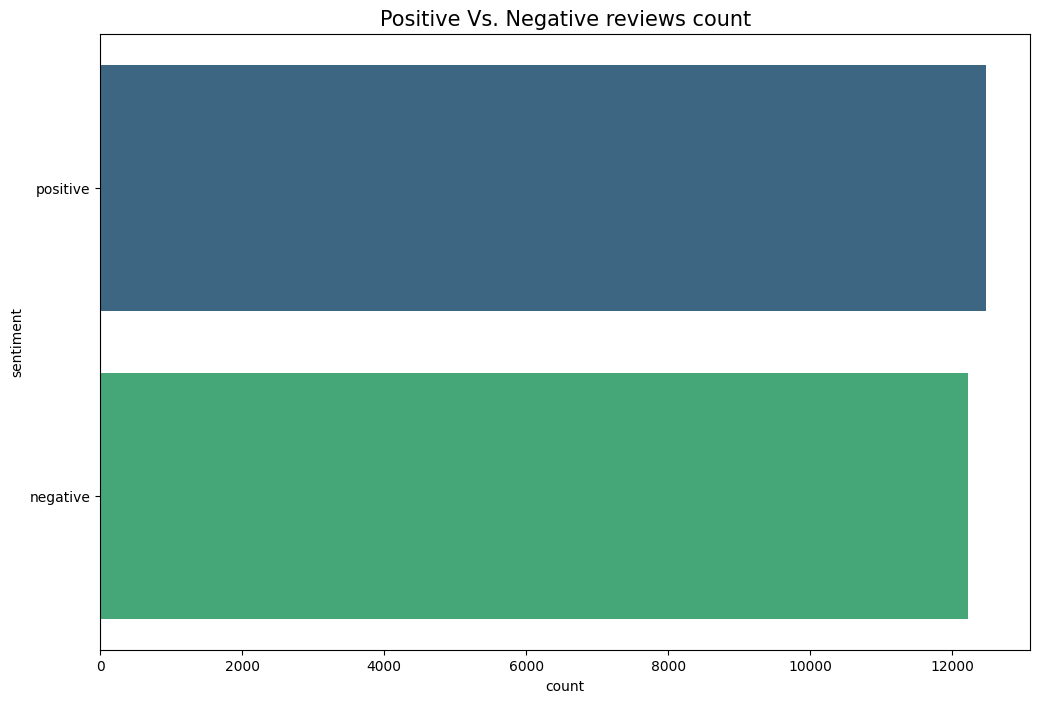

In [36]:
plt.figure(figsize = (12,8))
sns.countplot(df['sentiment'],palette='viridis')
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction.

Feel free to use 'resample' library from sklearn.

In [56]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment'] == 'positive']
df_minority = df[df['sentiment'] == 'negative']

negative_upsample = resample(df_minority, replace = True,
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [57]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in
## this cell.

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled['sentiment'] == 'negative'].shape

(12474, 2)

### Expected Output :
(12474, 2)

In [58]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled['sentiment'] == 'positive'].shape

(12474, 2)

### Expected Output :
(12474, 2)

In [59]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled'
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train['review'], positive_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train['sentiment'], positive_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test['review'], positive_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test['sentiment'] , positive_data_points_test['sentiment']])


In [60]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews.
print(y_train.value_counts())

sentiment
negative    10000
positive    10000
Name: count, dtype: int64


### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [61]:
print(y_test.value_counts())

sentiment
negative    2474
positive    2474
Name: count, dtype: int64


### Expected Output :
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (15 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction.

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words.

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [62]:
# TASK CELL
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review.

    '''
    # Convert to lowercase
    review = review.lower()

    # Remove links
    review = re.sub(r'http\S+|www\S+|https\S+', '', review, flags=re.MULTILINE)
    review = re.sub(r"[^a-zA-Z]", " ", review)
    # Remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    review_tokens = review.split()
    filtered_words = [word for word in review_tokens if word not in stop_words]

    # Apply stemming
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # Join words back into a single string
    review_cleaned = ' '.join(stemmed_words)

    return review_cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes.

In [63]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n = frequency.get((word, label), 0)

    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format.

In [64]:
## With the use of mapping function, we replace
## the label in the form of string to an integer.

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [65]:
## Ensuring that there are equal number of classes on the training data.
y_train.value_counts()

,count
sentiment,
1,10000
0,10000


In [66]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'No? Didn\'t think so! Well, in that case all you have to do is stay far, far away from "Do You Wanna Know A Secret", as it\'s just the umpteenth pointless post-"Scream" slasher with absolutely no redeeming value whatsoever. The plot is extremely ridiculous; the characters are insufferably dumb, the gore-factor is negligible and the whole thing is just plain boring! As you can derive from the title already, this film is mainly inspired by "I Still Know What You Did Last Summer", as the events take place in a similar setting and the killer\'s motivations are equally stupid. Why anyone would want to steal ideas from junk like "IKWYDLS" is a complete mystery to me, anyway. At least that film could depend on the precious rack of Jennifer Love Hewitt, whereas the girls in this junk are, apart from brainless, also terribly unattractive. One year after the still unsolved murder of her boyfriend, Beth Morgan, her new adulterous lover and four other simple-minded college students go to Florida 

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text.

Therefore, those words would be removed. It also reduces the computation time.

Therefore, it is a good practice we are following.

In [67]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

think well case stay far far away wanna know secret umpteenth pointless post scream slasher absolut redeem valu whatsoev plot extrem ridicul charact insuffer dumb gore factor neglig whole thing plain bore deriv titl alreadi film mainli inspir still know last summer event take place similar set killer motiv equal stupid anyon would want steal idea junk like ikwydl complet mysteri anyway least film could depend preciou rack jennif love hewitt wherea girl junk apart brainless also terribl unattract one year still unsolv murder boyfriend beth morgan new adulter lover four simpl mind colleg student go florida spend spring break holiday fanci beach hous killer made move year follow poss florida start butcher whilst leav behind titular messag sort busi card realli need horror expert order quickli figur face hide behind unspeak ridicul mask writer attempt put wrong track downright embarrass sinc plot thin film pure irrelev pad includ sub plot regard incompet floridian polic forc mysteri fbi in

We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model.

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews.

In this function, we count the occurrence of words and get the probabilities
for the words based on the training data.

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [68]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1

    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
        # Define the key as the tuple (word, label)
        key = (word, label)

        # if the key exists in the dictionary, increment the count
        if key in output_occurrence:
          output_occurrence[key]+=1
        else:
          output_occurrence[key] = 1

    return output_occurrence



### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results.

In [69]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [70]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [71]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels.
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('think', 1): 3587,
 ('well', 1): 3450,
 ('case', 1): 707,
 ('stay', 1): 509,
 ('far', 1): 1250,
 ('away', 1): 1139,
 ('wanna', 1): 86,
 ('know', 1): 3131,
 ('secret', 1): 294,
 ('umpteenth', 1): 8,
 ('pointless', 1): 355,
 ('post', 1): 212,
 ('scream', 1): 364,
 ('slasher', 1): 248,
 ('absolut', 1): 903,
 ('redeem', 1): 299,
 ('valu', 1): 509,
 ('whatsoev', 1): 228,
 ('plot', 1): 3496,
 ('extrem', 1): 659,
 ('ridicul', 1): 747,
 ('charact', 1): 5690,
 ('insuffer', 1): 18,
 ('dumb', 1): 512,
 ('gore', 1): 558,
 ('factor', 1): 129,
 ('neglig', 1): 16,
 ('whole', 1): 1482,
 ('thing', 1): 3802,
 ('plain', 1): 360,
 ('bore', 1): 1592,
 ('deriv', 1): 69,
 ('titl', 1): 793,
 ('alreadi', 1): 618,
 ('film', 1): 17873,
 ('mainli', 1): 146,
 ('inspir', 1): 210,
 ('still', 1): 1838,
 ('last', 1): 1228,
 ('summer', 1): 127,
 ('event', 1): 411,
 ('take', 1): 2554,
 ('place', 1): 1141,
 ('similar', 1): 304,
 ('set', 1): 1607,
 ('killer', 1): 711,
 ('motiv', 1): 229,
 ('equal', 1): 224,
 ('stupid', 

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells.

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function.

In [76]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set(word for review in train_x for word in clean_review(review).split())
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
          num_pos += freqs[pair]

        # else, the label is negative
        else:
          # increment the number of negative words by the count for this (word,label) pair
          num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)

    # Calculate D_pos, the number of positive documents
    pos_num_docs = sum(1 for y in train_y if y == 1)

    # Calculate D_neg, the number of negative documents
    neg_num_docs = num_doc - pos_num_docs

    # Calculate logprior
    logprior = math.log(pos_num_docs / num_doc)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = math.log(p_w_pos) - math.log(p_w_neg)


    return logprior, loglikelihood

In [77]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

-0.6931471805599453
43501


## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively.

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0.

In [84]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''

      # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob+= loglikelihood[word]

    #print(f"The total_probability is {total_prob}")

    #After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is
    #greater than 0 and 0(positive) if the sum of the log likelihood is less than or equal to 0.
    if total_prob > 0:
      return 1
    else:
      return 0

In [85]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set.

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'.

In [93]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0


    y_hats = []
    for review in test_x:
      total_prob = naive_bayes_predict(review, logprior, loglikelihood)
        # if the prediction is > 0
      if total_prob > 0:
        # the predicted class is 1
        y_hat_i = 1
      else:
        # otherwise the predicted class is 0
        y_hat_i = 0
      # append the predicted class to the list y_hats
      y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = sum(abs(y_hat - y_true) for y_hat, y_true in zip(y_hats, test_y)) / len(test_y)


    accuracy = 1 - error


    return accuracy

In [87]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')


If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [88]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (15 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changing seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [89]:
#1. Split your data into training and test sets using random selection.
#Set the seed as parameter of the function so that user can select a different training and test set by changing seed.
import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure the sentiment is encoded correctly (0 for negative, 1 for positive)
df_upsampled['sentiment'] = df_upsampled['sentiment'].map({'positive': 1, 'negative': 0})

# Splitting the data into positive and negative sentiment
positive_data = df_upsampled[df_upsampled['sentiment'] == 1]
negative_data = df_upsampled[df_upsampled['sentiment'] == 0]

# Splitting the data into training and testing sets with custom seed
def split_data(positive_data, negative_data, seed=None):
    # Specify the number of samples for training (10,000 for each class)
    n_train = 10000

    # Split both positive and negative data
    positive_train, positive_test = train_test_split(positive_data, train_size=n_train, random_state=seed)
    negative_train, negative_test = train_test_split(negative_data, train_size=n_train, random_state=seed)

    # Concatenate training sets
    X_train = pd.concat([positive_train['review'], negative_train['review']])
    y_train = pd.concat([positive_train['sentiment'], negative_train['sentiment']])

    # Concatenate test sets
    X_test = pd.concat([positive_test['review'], negative_test['review']])
    y_test = pd.concat([positive_test['sentiment'], negative_test['sentiment']])

    return X_train, X_test, y_train, y_test

# Call the function with a specific seed for reproducibility
seed = 42  # You can change the seed to test different splits
X_train, X_test, y_train, y_test = split_data(positive_data, negative_data, seed)

# Checking the shapes of the splits
print("Training Data - X:", X_train.shape, "y:", y_train.shape)
print("Test Data - X:", X_test.shape, "y:", y_test.shape)


Training Data - X: (20000,) y: (20000,)
Test Data - X: (4948,) y: (4948,)


In [92]:
#2: Train the Naive Bayes Model with the Training Set
# Compute word frequencies for the training data
freqs = review_counter({}, X_train, y_train)

# Train Naive Bayes to get logprior and loglikelihood
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

-0.6931471805599453
43606


In [94]:
from sklearn.metrics import confusion_matrix

#3: Test the Naive Bayes Model on both the training and test sets

# Confusion matrix for the training set
train_accuracy = test_naive_bayes(X_train, y_train, logprior, loglikelihood)
train_predictions = [naive_bayes_predict(review, logprior, loglikelihood) for review in X_train]
train_cm = confusion_matrix(y_train, train_predictions)
print(f"Confusion Matrix (Training Set):\n{train_cm}")

# Confusion matrix for the test set
test_accuracy = test_naive_bayes(X_test, y_test, logprior, loglikelihood)
test_predictions = [naive_bayes_predict(review, logprior, loglikelihood) for review in X_test]
test_cm = confusion_matrix(y_test, test_predictions)
print(f"Confusion Matrix (Test Set):\n{test_cm}")



Confusion Matrix (Training Set):
[[9536  464]
 [1260 8740]]
Confusion Matrix (Test Set):
[[2267  207]
 [ 446 2028]]


In [95]:
# 4: Examine False Positives and False Negatives

# Get False Positives and False Negatives
false_positives = [review for review, pred, true in zip(X_test, test_predictions, y_test) if pred == 1 and true == 0]
false_negatives = [review for review, pred, true in zip(X_test, test_predictions, y_test) if pred == 0 and true == 1]

print(f"Number of False Positives: {len(false_positives)}")
print(f"Number of False Negatives: {len(false_negatives)}")

# Print a few examples of false positives and false negatives
print("\nFalse Positives Example Reviews:")
for review in false_positives[:5]:
    print(review)

print("\nFalse Negatives Example Reviews:")
for review in false_negatives[:5]:
    print(review)


Number of False Positives: 207
Number of False Negatives: 446

False Positives Example Reviews:
DD films were damn corny, damn stupid and had a plot which seemed wafer thin but those days they was a plot at least<br /><br />This film isn't just a comedy but a mix of melodrama, romance everything<br /><br />Every drama scene is blown out of proportion<br /><br />The comedy is funny but corny too Yet the film keeps you entertained, those days Govinda films were loud, crass yet they had some funny moments people enjoyed<br /><br />David Dhawan does a okay job Music is okay<br /><br />Govinda acts well in comedy and drama Karisma is decent in parts and annoys in parts Kader is as usual Gulshan, Prem Chopra are typecast Shakti is hilarious
As an avid Gone With the Wind fan, I was disappointed to watch the original movie and see that they had left out many important characters. Luckily, the film on its own was a wonderful piece. When the book Scarlett came out, I read it in hopes of followin

# Q8. Theory Questions: (15 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

### Answer:
1.
- Laplace Smoothing (or Additive Smoothing) is required in Naive Bayes, especially for text classification tasks, to handle situations where a word from the test set doesn't appear in the training set.
- Laplace smoothing prevents zero probability when an unseen word appears in the test data. If a word is not in the training set, its probability would be zero, which would nullify the entire document’s classification.
- By adding a small constant (usually 1) to all word counts, it ensures that no probability is ever zero. This improves model robustness, avoids overfitting and generalizes better to new, unseen data.

2.

- Logarithmic values are used to avoid underflow that occurs when multiplying many small probabilities, which could lead to very small numbers that computers can't handle.
- Logarithms convert multiplication into addition, simplifying calculations and improving numerical stability. They also make the model more efficient and easier to interpret.